<a href="https://colab.research.google.com/github/0x6f736f646f/AI_LABS/blob/master/QuantumMachineLearning/3quantum_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Function fitting with a quantum neural network

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
%matplotlib inline

The device we use is the Strawberry Fields simulator, this time with
only one quantum mode (or ``wire``). You will need to have the
Strawberry Fields plugin for PennyLane installed.



In [2]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

Quantum node
~~~~~~~~~~~~

For a single quantum mode, each layer of the variational circuit is
defined as:



In [3]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.



In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

Objective
~~~~~~~~~

As an objective we take the square loss between target labels and model
predictions.



In [5]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).



In [6]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

Optimization
~~~~~~~~~~~~

We load noisy data samples of a sine function.



In [8]:
Xlim = 5
noise = np.random.normal(0,0.1,100) # generate noise to add to the function values (Y-values)
X = np.arange(-Xlim, Xlim, 0.1)
Y = np.sin(X)+noise

Before training a model, let’s examine the data.

*Note: For the next cell to work you need the matplotlib library.*



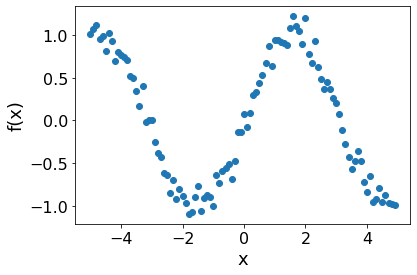

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()


The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.



In [10]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


Using the Adam optimizer, we update the weights for 50 steps (this
takes some time). More steps will lead to a better fit.



In [11]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(50):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.4059139 
Iter:     2 | Cost: 0.3869755 
Iter:     3 | Cost: 0.4175333 
Iter:     4 | Cost: 0.4639192 
Iter:     5 | Cost: 0.5078547 
Iter:     6 | Cost: 0.5395922 
Iter:     7 | Cost: 0.5550183 
Iter:     8 | Cost: 0.5538402 
Iter:     9 | Cost: 0.5382563 
Iter:    10 | Cost: 0.5119292 
Iter:    11 | Cost: 0.4791628 
Iter:    12 | Cost: 0.4442221 
Iter:    13 | Cost: 0.4107879 
Iter:    14 | Cost: 0.3815747 
Iter:    15 | Cost: 0.3581569 
Iter:    16 | Cost: 0.3410107 
Iter:    17 | Cost: 0.3297338 
Iter:    18 | Cost: 0.3233572 
Iter:    19 | Cost: 0.3206576 
Iter:    20 | Cost: 0.3204046 
Iter:    21 | Cost: 0.3215171 
Iter:    22 | Cost: 0.3231355 
Iter:    23 | Cost: 0.3246338 
Iter:    24 | Cost: 0.3255981 
Iter:    25 | Cost: 0.3257891 
Iter:    26 | Cost: 0.3251032 
Iter:    27 | Cost: 0.3235368 
Iter:    28 | Cost: 0.3211556 
Iter:    29 | Cost: 0.3180712 
Iter:    30 | Cost: 0.3144218 
Iter:    31 | Cost: 0.3103576 
Iter:    32 | Cost: 0.3060300 
Iter:   

In [12]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (green dots).



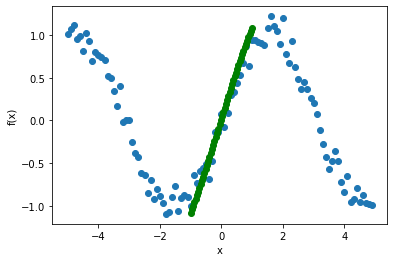

In [13]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).

